# **0. Hyperparameters**

## **0.1 Data Params**

In [1]:
CONTEXT_SIZE = 150                 # Number of tokens to consider in input
TOKENS_TO_PREDICT = 1              # Number of tokens to generate in output

NUM_BINS_INPUT = 150               # Number of bins for inputs
NUM_BINS_OUTPUT = 2                # Number of bins for targets

BATCH_SIZE = 15                    # Batch size

## **0.2 Model Params**

In [2]:
D_MODEL = 1024                     # Model dimension
NUM_HEADS = 16                     # Number of heads
D_K = int(D_MODEL / NUM_HEADS)     # Dimension of Q and K
D_V = D_K                          # Dimension of V
D_FF = 2048                        # Number of neurons in Feed Forward layer

NUM_LAYERS = 6                     # Number of Encoder/Decoder Stacks
DROPOUT_RATE = 0.1                 # Gloabl dropout rate
EPSILON = 0.00001                  # Constant added to ensure nonzero values
WARMUP_STEPS = 1000                # Warmup (linear increase in learning rate) steps before cooldown

# **1. Import and Install Dependencies**

## **1.1 Install Dependencies**

In [3]:
!pip install tensorflow tensorflow-gpu tensorflow-io matplotlib

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


## **1.2 Load Dependencies**

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, MultiHeadAttention, LayerNormalization, Dropout, Dense
from tensorflow.keras.models import Sequential
print(tf.__version__)

2.13.0


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# **2. Load Data**

## **2.1 Define Paths to Files**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
df = pd.read_csv('/content/drive/MyDrive/Data/AAPL 4.csv')
print(df.head())

         Date       Open       High        Low      Close  Adj Close  \
0  2013-09-23  17.717857  17.746786  17.235714  17.522858  15.293097   
1  2013-09-24  17.674286  17.695356  17.422144  17.467857  15.245091   
2  2013-09-25  17.471430  17.487143  17.193930  17.197500  15.009134   
3  2013-09-26  17.357143  17.448570  17.282143  17.365000  15.155321   
4  2013-09-27  17.277857  17.309643  17.168571  17.241072  15.047170   

      Volume  
0  762106800  
1  364344400  
2  316957200  
3  237221600  
4  228040400  


## **2.2 Read Data**

In [8]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-09-23,17.717857,17.746786,17.235714,17.522858,15.293097,762106800
1,2013-09-24,17.674286,17.695356,17.422144,17.467857,15.245091,364344400
2,2013-09-25,17.471430,17.487143,17.193930,17.197500,15.009134,316957200
3,2013-09-26,17.357143,17.448570,17.282143,17.365000,15.155321,237221600
4,2013-09-27,17.277857,17.309643,17.168571,17.241072,15.047170,228040400
...,...,...,...,...,...,...,...
2511,2023-09-14,174.000000,176.100006,173.580002,175.740005,175.740005,60895800
2512,2023-09-15,176.479996,176.500000,173.820007,175.009995,175.009995,109205100
2513,2023-09-18,176.479996,179.380005,176.169998,177.970001,177.970001,67257600
2514,2023-09-19,177.520004,179.630005,177.130005,179.070007,179.070007,51826900


In [9]:
cols = list(df)[0:7]
print(cols)

['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


In [10]:
numSamples = df.shape[0] - 1
PctReturns = np.zeros((numSamples))

In [11]:
sampleIdx = 0
while sampleIdx < numSamples:
  prevClose = float(df['Close'][sampleIdx])
  todayClose = float(df['Close'][sampleIdx+1])
  PctReturns[sampleIdx] = (todayClose - prevClose) / prevClose * 100
  sampleIdx += 1

In [12]:
PctReturns

array([-0.31388145, -1.54773994,  0.97397878, ...,  1.6913354 ,
        0.61808507, -1.99921922])

## **2.3 Plot Data**

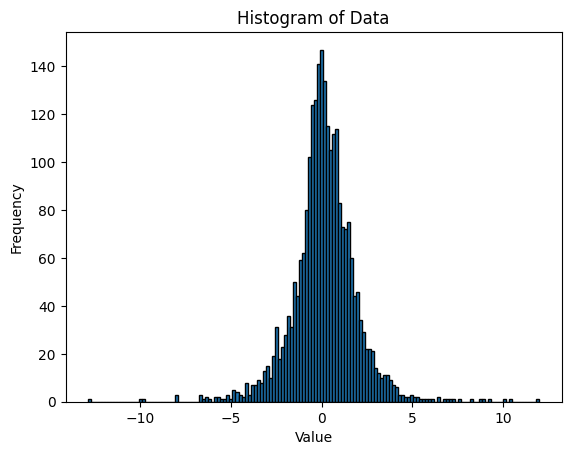

In [13]:
# Create a histogram
plt.hist(PctReturns, bins=NUM_BINS_INPUT, edgecolor='k')  # You can adjust the number of bins as needed

# Add labels and a title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data')

# Show the plot
plt.show()

# **3. Pre-Process Data**

## **3.1 Normalize**

In [14]:
PctReturns = (PctReturns - np.average(PctReturns)) / np.std(PctReturns)

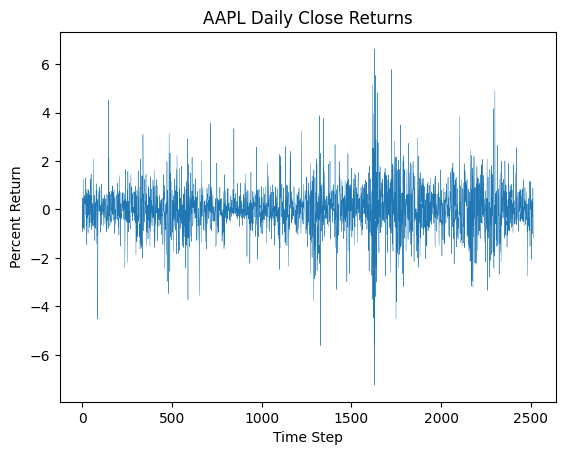

In [15]:
plt.plot(PctReturns, linewidth=0.3)
plt.ylabel('Percent Return')
plt.xlabel('Time Step')
plt.title('AAPL Daily Close Returns')
plt.show()

In [16]:
INPUT_VOCAB_SIZE = NUM_BINS_INPUT
OUTPUT_VOCAB_SIZE = NUM_BINS_OUTPUT + 1   # includes start token (0)
retMax = np.max(PctReturns)
retMin = np.min(PctReturns)
distance = retMax - retMin
inputBinSize = distance / NUM_BINS_INPUT

## **3.2 Vocab Functions for Tokenization and Detokenization**

In [17]:
def getVocabIdxInput(x):
  global retMax, retMin, distance, inputBinSize, NUM_BINS_INPUT
  binNumber = int(np.floor((x - retMin) / inputBinSize))
  return min(binNumber, NUM_BINS_INPUT)

def getVocabIdxOutput(x):
  temp = 1
  if x > 0:
    temp = 2
  return temp

In [18]:
PctReturns[0]

-0.2352648727570541

In [19]:
getVocabIdxInput(PctReturns[0])

75

## **3.3 Tokenize Data for Input Vocab and Output Vocab**

In [20]:
tokenizedReturnsIn = np.zeros((numSamples), dtype=np.int32)
tokenizedReturnsOut = np.zeros((numSamples), dtype=np.int32)
i = 0
while i < numSamples:
  tokenizedReturnsIn[i] = getVocabIdxInput(PctReturns[i])
  tokenizedReturnsOut[i] = getVocabIdxOutput(PctReturns[i])
  i += 1

## **3.4 Create Inputs, Targets, Labels**

In [21]:
NUM_DATA_SAMPLES = numSamples - (CONTEXT_SIZE + TOKENS_TO_PREDICT)
inputX = np.zeros((NUM_DATA_SAMPLES, CONTEXT_SIZE), dtype=np.int32)
inputY = np.zeros((NUM_DATA_SAMPLES, TOKENS_TO_PREDICT), dtype=np.int32)
trueY = np.zeros((NUM_DATA_SAMPLES, TOKENS_TO_PREDICT), dtype=np.int32)

In [22]:
dataSampleIdx = 0
while dataSampleIdx < NUM_DATA_SAMPLES:
  inputX[dataSampleIdx, :] = tokenizedReturnsIn[dataSampleIdx:dataSampleIdx+CONTEXT_SIZE]
  inputY[dataSampleIdx, 1:] = tokenizedReturnsOut[dataSampleIdx+CONTEXT_SIZE:dataSampleIdx+CONTEXT_SIZE+TOKENS_TO_PREDICT-1]
  trueY[dataSampleIdx, :] = tokenizedReturnsOut[dataSampleIdx+CONTEXT_SIZE:dataSampleIdx+CONTEXT_SIZE+TOKENS_TO_PREDICT]
  dataSampleIdx += 1

## **3.5 Check for NaN Values**

In [23]:
# Loop through inputX
for i in range(inputX.shape[0]):
    for j in range(inputX.shape[1]):
        if np.isnan(inputX[i, j]):
            print(f"NaN found in inputX at index ({i}, {j})")

# Loop through inputY
for i in range(inputY.shape[0]):
    for j in range(inputY.shape[1]):
        if np.isnan(inputY[i, j]):
            print(f"NaN found in inputY at index ({i}, {j})")

# Loop through trueY
for i in range(trueY.shape[0]):
    for j in range(trueY.shape[1]):
        if np.isnan(trueY[i, j]):
            print(f"NaN found in trueY at index ({i}, {j})")

## **3.6 Check Data**

In [24]:
sample = 99     # sample to check

In [25]:
tokenizedReturnsIn[sample:sample+CONTEXT_SIZE+TOKENS_TO_PREDICT]

array([ 77,  79,  68,  70,  70,  80,  71,  72,  89,  76,  79,  81,  78,
        75,  77,  78,  83,  78,  70,  70,  80,  83,  77,  74,  82,  84,
        84,  71,  75,  76,  77,  83,  78,  73,  69,  68,  77,  85,  69,
        73,  80,  73,  78,  84,  84,  78,  69, 127,  82, 101,  75,  75,
        79,  78,  86,  71,  75,  73,  75,  85,  78,  77,  72,  86,  84,
        77,  79,  78,  84,  88,  76,  88,  75,  73,  86,  84,  80,  76,
        87,  81,  75,  67,  71,  83,  76,  78,  75,  71,  77,  74,  78,
        81,  84,  83,  81,  77,  81,  90,  73,  77,  75,  78,  85,  70,
        74,  66,  86,  74,  82,  93,  76,  81,  86,  73,  76,  61,  81,
        74,  74,  76,  74,  79,  85,  77,  85,  79,  80,  84,  86,  77,
        77,  82,  78,  73,  85,  78,  79,  82,  52,  72,  82,  73,  75,
        96,  80,  79,  77,  73,  81,  78,  72], dtype=int32)

In [26]:
inputX[sample, :]

array([ 77,  79,  68,  70,  70,  80,  71,  72,  89,  76,  79,  81,  78,
        75,  77,  78,  83,  78,  70,  70,  80,  83,  77,  74,  82,  84,
        84,  71,  75,  76,  77,  83,  78,  73,  69,  68,  77,  85,  69,
        73,  80,  73,  78,  84,  84,  78,  69, 127,  82, 101,  75,  75,
        79,  78,  86,  71,  75,  73,  75,  85,  78,  77,  72,  86,  84,
        77,  79,  78,  84,  88,  76,  88,  75,  73,  86,  84,  80,  76,
        87,  81,  75,  67,  71,  83,  76,  78,  75,  71,  77,  74,  78,
        81,  84,  83,  81,  77,  81,  90,  73,  77,  75,  78,  85,  70,
        74,  66,  86,  74,  82,  93,  76,  81,  86,  73,  76,  61,  81,
        74,  74,  76,  74,  79,  85,  77,  85,  79,  80,  84,  86,  77,
        77,  82,  78,  73,  85,  78,  79,  82,  52,  72,  82,  73,  75,
        96,  80,  79,  77,  73,  81,  78], dtype=int32)

In [27]:
inputY[sample, :]

array([0], dtype=int32)

In [28]:
trueY[sample, :]

array([1], dtype=int32)

In [29]:
tokenizedReturnsOut[sample:sample+CONTEXT_SIZE+TOKENS_TO_PREDICT]

array([1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2,
       1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2,
       2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1,
       2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1,
       1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2,
       1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2,
       2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1],
      dtype=int32)

## **3.7 Partition Data Into Train/Test**

In [30]:
NUM_BATCHES = int(np.floor(NUM_DATA_SAMPLES / BATCH_SIZE))
BATCHES_TO_TRAIN = int(np.round(0.8*NUM_BATCHES))
SAMPLES_TO_TRAIN = BATCHES_TO_TRAIN * BATCH_SIZE

In [31]:
inputX_train = inputX[0:SAMPLES_TO_TRAIN, :]
inputX_val = inputX[SAMPLES_TO_TRAIN:BATCH_SIZE*NUM_BATCHES, :]

inputY_train = inputY[0:SAMPLES_TO_TRAIN,:]
inputY_val = inputY[SAMPLES_TO_TRAIN:BATCH_SIZE*NUM_BATCHES, :]

trueY_train = trueY[0:SAMPLES_TO_TRAIN,:]
trueY_val = trueY[SAMPLES_TO_TRAIN:BATCH_SIZE*NUM_BATCHES, :]

# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices(((inputX_train, inputY_train), trueY_train))     # slices along the first axis of both sets
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)     # creates batches of slices, of size batch_size

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices(((inputX_val, inputY_val), trueY_val))
val_dataset = val_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

In [32]:
train_dataset
val_dataset

<_BatchDataset element_spec=((TensorSpec(shape=(None, 150), dtype=tf.int32, name=None), TensorSpec(shape=(None, 1), dtype=tf.int32, name=None)), TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))>

# **4. Build and Test Functions for Transformer Model**

## **4.1 Grab a Batch for Testing**

In [33]:
for (batch, ((x_batch_train, y_batch_train), true_y_batch_train)) in enumerate(train_dataset):
  break

In [34]:
print(x_batch_train)
print(y_batch_train)
print(true_y_batch_train)

tf.Tensor(
[[ 86  71  79 ...  88  77  80]
 [ 74  75  60 ...  78  75  80]
 [ 73  86  84 ...  70  66  71]
 ...
 [ 73  75  96 ...  82  80  76]
 [ 77  67  67 ...  52  75  69]
 [ 82 100  75 ...  76  81  86]], shape=(15, 150), dtype=int32)
tf.Tensor(
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]], shape=(15, 1), dtype=int32)
tf.Tensor(
[[2]
 [1]
 [1]
 [1]
 [1]
 [2]
 [2]
 [2]
 [1]
 [1]
 [2]
 [1]
 [1]
 [2]
 [1]], shape=(15, 1), dtype=int32)


## **4.2 Embeddings**

In [35]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)


class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)  # Add mask_zero=True here
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, inputs, mask=None):
    # The mask returned by this layer is the same as the one received (identity mask).
    return mask

  def call(self, x, mask=None):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positional_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [36]:
# We only use one embedder since the input and output vocab are the same
# (use two embedders if it's a vision transformer, one language to another
# language, etc)
gen_embed = PositionalEmbedding(vocab_size=INPUT_VOCAB_SIZE, d_model=D_MODEL)

x_emb = gen_embed(x_batch_train)
y_emb = gen_embed(y_batch_train)

print(f'x_emb shape: {x_emb.shape}')
print(f'y_emb shape: {y_emb.shape}')

x_emb shape: (15, 150, 1024)
y_emb shape: (15, 1, 1024)


## **4.3 Attention Types**

In [37]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

In [38]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [39]:
sample_ca = CrossAttention(num_heads=NUM_HEADS, key_dim=D_K)

print(sample_ca(x_emb, y_emb).shape)

(15, 150, 1024)


In [40]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [41]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(sample_gsa(x_emb).shape)

(15, 150, 1024)


In [42]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [43]:
sample_csa = CausalSelfAttention(num_heads=NUM_HEADS, key_dim=D_K)

print(sample_csa(y_emb).shape)

(15, 1, 1024)


## **4.4 Feed Forward**

In [44]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

In [45]:
sample_ffn = FeedForward(D_MODEL, D_FF)

print(sample_ffn(y_emb).shape)

(15, 1, 1024)


## **4.5 Encoder Layer**

In [46]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [47]:
sample_encoder_layer = EncoderLayer(d_model=D_MODEL, num_heads=NUM_HEADS, dff=D_FF)

print(sample_encoder_layer(x_emb).shape)

(15, 150, 1024)


## **4.6 Encoder Block**

In [48]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

In [49]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=NUM_LAYERS,
                         d_model=D_MODEL,
                         num_heads=NUM_HEADS,
                         dff=D_FF,
                         vocab_size=INPUT_VOCAB_SIZE)

sample_encoder_output = sample_encoder(x_batch_train, training=False)

# Print the shape.
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(15, 150, 1024)


## **4.7 Decoder Layer**

In [50]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [51]:
sample_decoder_layer = DecoderLayer(d_model=D_MODEL, num_heads=NUM_HEADS, dff=D_FF)

sample_decoder_layer_output = sample_decoder_layer(
    x=y_emb, context=x_emb)

print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

(15, 1, 1024)


## **4.8 Decoder Block**

In [52]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [53]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=NUM_LAYERS,
                         d_model=D_MODEL,
                         num_heads=NUM_HEADS,
                         dff=D_FF,
                         vocab_size=OUTPUT_VOCAB_SIZE)

output = sample_decoder(
    x = y_batch_train,
    context = x_emb)

# Print the shapes.
print(x_batch_train.shape)
print(x_emb.shape)
print(output.shape)

(15, 150)
(15, 150, 1024)
(15, 1, 1024)


In [54]:
sample_decoder.last_attn_scores.shape  # (batch, heads, target_seq, input_seq)

TensorShape([15, 16, 1, 150])

# **5. Build Model**

## **5.1 Transformer**

In [55]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

In [56]:
transformer = Transformer(
    num_layers = NUM_LAYERS,
    d_model = D_MODEL,
    num_heads = NUM_HEADS,
    dff = D_FF,
    input_vocab_size = INPUT_VOCAB_SIZE,
    target_vocab_size = OUTPUT_VOCAB_SIZE,
    dropout_rate = DROPOUT_RATE)

In [57]:
output = transformer((x_batch_train, y_batch_train))

print(y_batch_train.shape)
print(x_batch_train.shape)
print(output.shape)
print(true_y_batch_train.shape)

(15, 1)
(15, 150)
(15, 1, 3)
(15, 1)


In [58]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(15, 16, 1, 150)


In [59]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  428316672 
                                                                 
 decoder_1 (Decoder)         multiple                  831132672 
                                                                 
 dense_54 (Dense)            multiple                  3075      
                                                                 
Total params: 1259452419 (4.69 GB)
Trainable params: 1259452419 (4.69 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## **5.2 Learning Rate**

In [60]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=WARMUP_STEPS):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [61]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

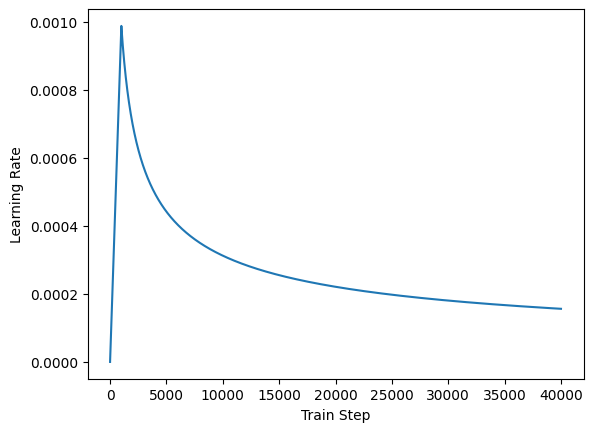

In [62]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

## **5.3 Loss**

In [63]:
def masked_loss(label, pred):
  mask = label != -1
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != -1

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

## **5.4 Compile Model**

In [64]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

# **6. Training**

## **6.1 Fit**

In [ ]:
# Fit the model using NumPy arrays
transformer.fit(train_dataset,
    epochs=200,
    validation_data=val_dataset
)

Epoch 1/200
126/126 [==============================] - 81s 252ms/step - loss: 0.8946 - masked_accuracy: 0.5095 - val_loss: 0.7139 - val_masked_accuracy: 0.4860
Epoch 2/200
126/126 [==============================] - 29s 227ms/step - loss: 0.8038 - masked_accuracy: 0.5005 - val_loss: 1.1709 - val_masked_accuracy: 0.4860
Epoch 3/200
126/126 [==============================] - 29s 228ms/step - loss: 0.7532 - masked_accuracy: 0.5101 - val_loss: 0.7688 - val_masked_accuracy: 0.4860
Epoch 4/200
126/126 [==============================] - 28s 226ms/step - loss: 0.7477 - masked_accuracy: 0.4995 - val_loss: 0.8767 - val_masked_accuracy: 0.4860
Epoch 5/200
126/126 [==============================] - 28s 226ms/step - loss: 0.7361 - masked_accuracy: 0.5021 - val_loss: 0.6989 - val_masked_accuracy: 0.5140
Epoch 6/200
126/126 [==============================] - 28s 226ms/step - loss: 0.7150 - masked_accuracy: 0.5026 - val_loss: 0.7553 - val_masked_accuracy: 0.5140
Epoch 7/200
126/126 [===================

# **WORK IN PROGRESS PAST THIS POINT - DEPRECATED CODE FROM PRIOR IMPLEMENTATION - PROCEED AT YOUR OWN RISK**

# **7. Testing**

In [ ]:
# Define a directory to save the model
model_dir = '/content/drive/MyDrive/Saved_Models'

In [ ]:
# Save the model
tf.saved_model.save(transformer, model_dir)

In [ ]:
# Load a saved model (optional)
loaded_model = tf.saved_model.load(model_dir)

In [ ]:
tokToShow = 2

x_in = np.reshape(inputX_train[0, :], (1, MAX_TOKENS))
y_in = np.reshape(inputY_train[0, 0:tokToShow], (1, tokToShow))

In [ ]:
x_in

In [ ]:
y_in

In [ ]:
output = transformer((x_in, y_in), training=False)[0, tokToShow-1, :].numpy()
outputTok = np.argmax(output)
outputTok

In [ ]:
class Responder(tf.Module):
  def __init__(self, transformer):
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    x_in = tokenize_and_pad_training([sentence])[:, 0:MAX_TOKENS]
    y_in = np.zeros((1, MAX_TOKENS)).astype(np.int32)
    startTok = Vocab[1]
    inputToks = [startTok]
    outputWords = []
    lastTok = 1
    tokToShow = 1
    while outputTok != 2 and tokToShow < MAX_TOKENS:
      y_in[0, tokToShow-1] = lastTok


In [ ]:
def ReplyBot(sentence):
  x_in = tokenize_and_pad_training([sentence])[:, 0:MAX_TOKENS]
  y_in = np.zeros((1, MAX_TOKENS)).astype(np.int32)
  startTok = Vocab[1]
  inputToks = [startTok]
  outputWords = []
  lastTok = 1
  tokToShow = 1
  while lastTok != 2 and tokToShow < MAX_TOKENS:
    y_in[0, tokToShow-1] = lastTok
    output = transformer((x_in, y_in), training=False)[0, tokToShow-1, :].numpy()
    lastTok = np.argmax(output)
    outputWords.append(Vocab[lastTok, 0])
    tokToShow += 1
  endTok = Vocab[2, 0]
  outputWords.remove(endTok)
  response = "".join(outputWords)
  print(response)

In [ ]:
sentence = 'What is gravity?'
ReplyBot(sentence)

Ignore

In [ ]:
sample = 0
nextTok = 0
outputToks = []
outputTok = 0

tokToShow = 1
while outputTok != 2 and tokToShow < MAX_TOKENS:
  x_in = np.reshape(inputX_train[sample, :], (1, MAX_TOKENS))
  y_in = np.reshape(inputY_train[sample, 0:tokToShow], (1, tokToShow))
  output = transformer((x_in, y_in), training=False)[0, -1, :].numpy()
  outputTok = np.argmax(output)
  outputToks.append(outputTok)
  tokToShow += 1



In [ ]:
trueToks = np.reshape(trueY[sample, :], (1, MAX_TOKENS))
print(f'True Tokens: {trueToks}')
predToks = np.reshape(np.array(outputToks), (1, len(outputToks)))
print(f'Predicted Tokens: {predToks}')

Saving

In [ ]:
from tensorflow.keras.models import load_model
transformer.save('/content/drive/MyDrive/Transformer_1.hdf5')

In [ ]:
class Speaker(tf.Module):
  def __init__(self, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

In [ ]:
translator = Translator(transformer)

In [ ]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

# **8. Other Functions**

In [ ]:
for (batch, ((x_batch_train, y_batch_train), one_hot_y_batch_train)) in enumerate(train_dataset):
  break

In [ ]:
def speak(input):
  global MAX_TOKENS
  responses = []
  x_in = input
  y_in = np.array([[1]])
  nextToken = np.argmax(transformer([x_in, y_in], training=False).numpy())
  nextWord = Vocab[nextToken,0]
  responses.append(nextWord)
  numResponses = 1
  while nextWord != Vocab[2,:] and numResponses < MAX_TOKENS:
    y_in = np.concatenate((y_in, np.reshape(np.array(nextToken), (1,1))), axis=1)
    nextToken = np.argmax(transformer([x_in, y_in], training=False).numpy())
    nextWord = Vocab[nextToken,0]
    responses.append(nextWord)
    numResponses += 1
  print("".join(responses))

In [ ]:
question = np.reshape(tempX[0], (1, MAX_TOKENS))
print(speak(question))

In [ ]:
x_in = np.reshape(tempX[0], (1, MAX_TOKENS))
y_in = np.array([[4]])
response = transformer([x_in, y_in], training=False)
response_np = response.numpy()
idx = np.argmax(response_np)
print(idx)